In [265]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [266]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

VGG16

Computing mean distance.

Initialization for the layer in NN: 

$W_i \sim U(-\sqrt{k}, \sqrt{k})$
where $k = \frac 1 {N_{in}}$

$N_{in}$ - nubmer of input parameters for the weights. 

$N_{w}$ - numver of weights in the layer.

mean square dist between two layers in Linear layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \frac{ \left (2 \sqrt k \right )^2} {12}  = \frac {2 N_{w}} {3 N_{in}}$

for convolution layer:

$E [dist^2(L^1, L^2)] = E\sum_i (L_1^i-L_i^2)^2 = N_{w} (2 E (L_i^1)^2) = 2 N_{w} \left (\sqrt \frac 2 {n} \right )$

where n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels

In [287]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

In [288]:
# for m in self.modules():
#     if isinstance(m, nn.Conv2d):
#         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#         m.weight.data.normal_(0, math.sqrt(2. / n))
#         m.bias.data.zero_()

In [289]:
# distance for VGG16 network:
DIST = 0
i=1
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
        print(i, m)
        i+=1
        N_in = m.in_channels*np.prod(m.kernel_size)
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        N_w = np.prod(m.weight.shape)
#         +np.prod(m.bias.shape)
        print('N_in', N_in)
        print('N_w', N_w)
        DIST+=2*N_w*2/n
    if isinstance(m, torch.nn.Linear):
        print(i, m)
        i+=1
        N_in = m.in_features
        N_w = np.prod(m.weight.shape)+np.prod(m.bias.shape)
        print('N_in', N_in)
        print('N_w', N_w)
        DIST+=2/3*float(N_w)/float(N_in)
        

print()        
print('Distance', (np.sqrt(DIST)))

1 Linear(in_features=784, out_features=2000, bias=True)
N_in 784
N_w 1570000
2 Linear(in_features=2000, out_features=10, bias=True)
N_in 2000
N_w 20010

Distance 36.629278092878685


In [310]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [325]:
architecture = getattr(models, "LogRegression") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)
m = architecture.base(num_classes=10, **architecture.kwargs)
model_Arc = architecture.base(num_classes=10, **architecture.kwargs)

model5 = architecture.base(num_classes=10, **architecture.kwargs)
# model5.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-0.pt')['model_state'])

model1.load_state_dict(torch.load('curves_mnist/LogRegression/curve1/checkpoint-20.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LogRegression/curve2/checkpoint-20.pt')['model_state'])

# model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
# model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])
# model_Arc.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
# model4.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])

In [326]:
distance(model1, model2)

2.1721811

In [327]:
# train_res = utils.test(loaders['train'], model1, criterion, regularizer)
# test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
# train_res, test_res

In [328]:
for parameter, p1, p2 in zip(model5.parameters(), model1.parameters(), model2.parameters()):
    parameter.data.copy_((p1+p2)/2)

In [329]:
train_res = utils.test(loaders['train'], model1, criterion, regularizer)
test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
train_res, test_res

({'accuracy': 92.26833333333333,
  'loss': 0.27954975148042044,
  'nll': 0.27954975148042044},
 {'accuracy': 92.2, 'loss': 0.2778824174404144, 'nll': 0.2778824174404144})

In [330]:
train_res = utils.test(loaders['train'], model2, criterion, regularizer)
test_res = utils.test(loaders['test'], model2, criterion, regularizer) 
train_res, test_res

({'accuracy': 92.24666666666667,
  'loss': 0.27943755577405294,
  'nll': 0.27943755577405294},
 {'accuracy': 92.22, 'loss': 0.2780550070285797, 'nll': 0.2780550070285797})

In [331]:
train_res = utils.test(loaders['train'], model5, criterion, regularizer)
test_res = utils.test(loaders['test'], model5, criterion, regularizer) 
train_res, test_res

({'accuracy': 92.26666666666667,
  'loss': 0.279446321105957,
  'nll': 0.279446321105957},
 {'accuracy': 92.21, 'loss': 0.27792188935279843, 'nll': 0.27792188935279843})

In [274]:
ind = 1
T = True

while ind<22:

    ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
    checkpoint = torch.load(ckpt)
    m.load_state_dict(checkpoint['model_state'])
    
    for parameter, p in zip(model4.parameters(), m.parameters()):
        if ind == 1:
            parameter.data.copy_((p))
        else:
            parameter.data.copy_((parameter+p))
            
    ind+=1

print('ind', ind)
for parameter in model4.parameters():
    parameter.data.copy_(parameter/ind)


ind 22


In [275]:
for i, (parameter, p1, p2, mu) in enumerate(zip(model_Arc.parameters(), model1.parameters(), model2.parameters(), model4.parameters())):    
    if i!=3:
        parameter.data.copy_(mu + (1/np.sqrt(2))*(p1-mu)+(1/np.sqrt(2))*(p2-mu))
    

In [276]:
checkpoints = torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')

print("Saving checkpoint for node changing")

utils.save_checkpoint(
            'curves_mnist/LinearOneLayer/curve3',
            100,
            name='E',
            model_state=model4.state_dict(),
            optimizer_state=checkpoints['optimizer_state']
            )

Saving checkpoint for node changing


In [12]:
import utils

In [13]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, model3.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [14]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [15]:
list(model_Arc.parameters())[-1]

Parameter containing:
tensor([-0.1453,  0.1489, -0.0173, -0.1036, -0.0015,  0.1710, -0.0029,  0.1019,
        -0.1175, -0.0032], requires_grad=True)

In [16]:
list(model1.parameters())[-1]

Parameter containing:
tensor([-0.1453,  0.1489, -0.0173, -0.1036, -0.0015,  0.1710, -0.0029,  0.1019,
        -0.1175, -0.0032], requires_grad=True)

In [17]:
list(model2.parameters())[-1]

Parameter containing:
tensor([-0.1460,  0.1592, -0.0186, -0.1145,  0.0061,  0.2123, -0.0114,  0.0754,
        -0.1284, -0.0018], requires_grad=True)

In [18]:
train_res = utils.test(loaders['train'], model_Arc, criterion, regularizer)
test_res = utils.test(loaders['test'], model_Arc, criterion, regularizer) 
train_res, test_res

({'accuracy': 96.26166666666667,
  'loss': 0.14937926355202993,
  'nll': 0.14937926355202993},
 {'accuracy': 95.91, 'loss': 0.1539917501449585, 'nll': 0.1539917501449585})

In [308]:
train_res = utils.test(loaders['train'], model5, criterion, regularizer)
test_res = utils.test(loaders['test'], model5, criterion, regularizer) 
train_res, test_res

({'accuracy': 8.013333333333334,
  'loss': 2.315858253097534,
  'nll': 2.315858253097534},
 {'accuracy': 7.37, 'loss': 2.315081142807007, 'nll': 2.315081142807007})

In [19]:
train_res = utils.test(loaders['train'], model1, criterion, regularizer)
test_res = utils.test(loaders['test'], model1, criterion, regularizer) 
train_res, test_res

({'accuracy': 97.49, 'loss': 0.09569889086882273, 'nll': 0.09569889086882273},
 {'accuracy': 96.85, 'loss': 0.10649033370018006, 'nll': 0.10649033370018006})

In [314]:
train_res = utils.test(loaders['train'], model4, criterion, regularizer)
test_res = utils.test(loaders['test'], model4, criterion, regularizer) 
train_res, test_res

({'accuracy': 11.886666666666667,
  'loss': 2.287731131617228,
  'nll': 2.287731131617228},
 {'accuracy': 11.68, 'loss': 2.289980832290649, 'nll': 2.289980832290649})

In [21]:
train_res = utils.test(loaders['train'], model2, criterion, regularizer)
test_res = utils.test(loaders['test'], model2, criterion, regularizer) 
train_res, test_res

({'accuracy': 97.48166666666667,
  'loss': 0.09568042931556701,
  'nll': 0.09568042931556701},
 {'accuracy': 96.9, 'loss': 0.10741572513580322, 'nll': 0.10741572513580322})

In [22]:
train_res = utils.test(loaders['train'], model3, criterion, regularizer)
test_res = utils.test(loaders['test'], model3, criterion, regularizer) 
train_res, test_res

({'accuracy': 94.39333333333333,
  'loss': 0.3771916723251343,
  'nll': 0.3771916723251343},
 {'accuracy': 94.37, 'loss': 0.37200074133872985, 'nll': 0.37200074133872985})

In [23]:
list(model1.parameters())[0].shape, list(model1.parameters())[1].shape, list(model1.parameters())[2].transpose(0,1).shape

(torch.Size([2000, 784]), torch.Size([2000]), torch.Size([2000, 10]))

In [301]:
def samples(model):
    p1 = list(model.parameters())[0].data.numpy()
    p2 = list(model.parameters())[1].data.numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.numpy()
#     print(p1.shape, p2.shape, p3.shape)
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [25]:
S1 = 2000*samples(model1)
S2 = 2000*samples(model2)

In [26]:
CM1 = np.cov(S1, rowvar=False)
CM2 = np.cov(S2, rowvar=False)

In [30]:
from scipy.stats import kde

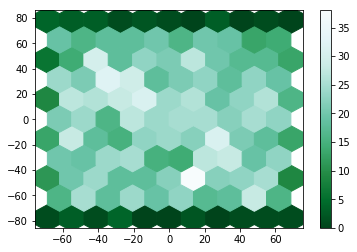

In [31]:
plt.hexbin(S1[:, 0], S1[:, 70], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()


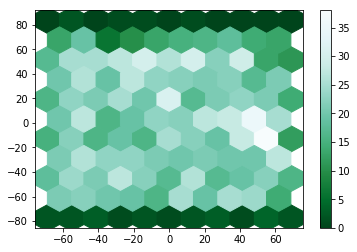

In [32]:
plt.hexbin(S2[:, 0], S2[:, 70], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()

In [33]:
from sklearn.manifold import TSNE

In [34]:
X_embedded1 = TSNE(n_components=2).fit_transform(S1)
X_embedded2 = TSNE(n_components=2).fit_transform(S2)

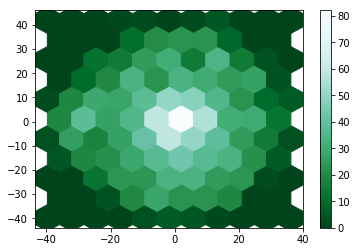

In [35]:
plt.hexbin(X_embedded1[:, 0], X_embedded1[:, 1], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()

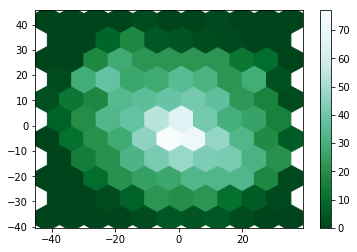

In [36]:
plt.hexbin(X_embedded2[:, 0], X_embedded2[:, 1], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()

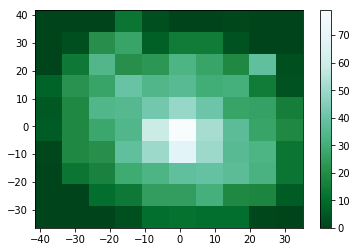

In [37]:
plt.hist2d(X_embedded2[:, 0], X_embedded2[:, 1], bins=10, cmap=plt.cm.BuGn_r);
plt.colorbar()

In [38]:
k = kde.gaussian_kde(X_embedded2.T)

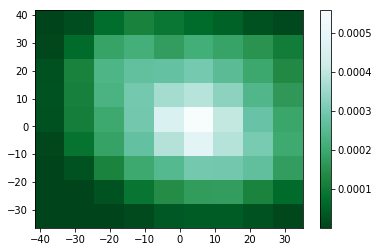

In [39]:
x, y = X_embedded2[:, 0], X_embedded2[:, 1]
nbins = 10
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
plt.colorbar()


In [40]:
import seaborn as sns

In [305]:
S_initial1 = samples(model5)

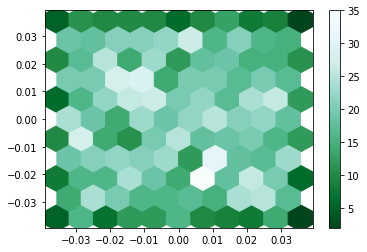

In [307]:
plt.hexbin(S_initial1[:, 0], S_initial1[:, 70], gridsize=10, cmap=plt.cm.BuGn_r)
plt.colorbar()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


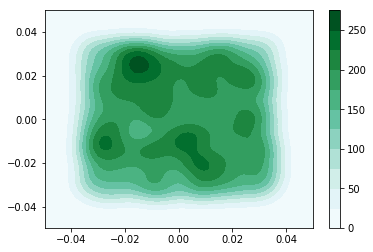

In [306]:
sns.kdeplot(S_initial1[:, 0], S_initial1[:, 1], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


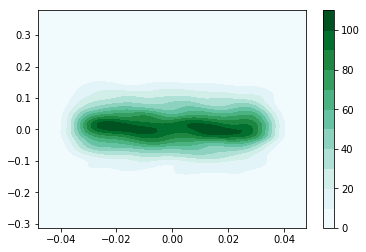

In [298]:
sns.kdeplot(1/2000*S1[:, 0], 1/2000*S1[:, 790], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


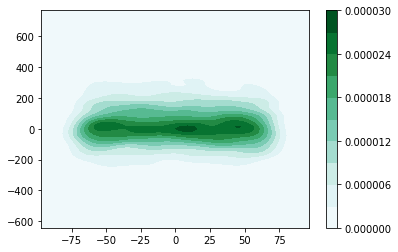

In [297]:
sns.kdeplot(S2[:, 0], S2[:, 790], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


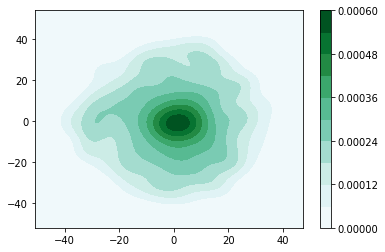

In [43]:
sns.kdeplot(X_embedded1[:, 0], X_embedded1[:, 1], shade=True, cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


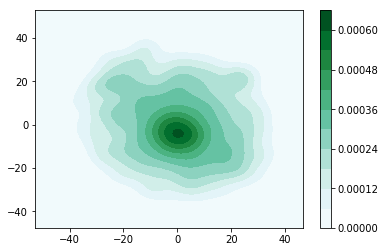

In [44]:
sns.kdeplot(X_embedded2[:, 0], X_embedded2[:, 1], shade=True, cbar=True)

In [45]:
from sklearn.decomposition import PCA

In [46]:
pca = PCA(n_components=2, svd_solver='full')
PCA1 = pca.fit_transform(S1)  
PCA2 = pca.fit_transform(S2)  

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


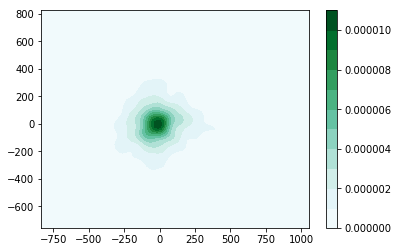

In [47]:
sns.kdeplot(PCA1[:, 0], PCA1[:, 1], shade=True, cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


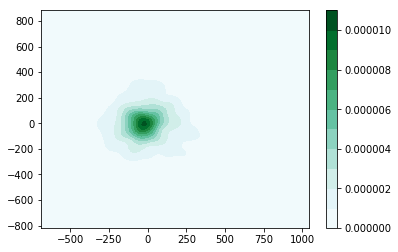

In [48]:
sns.kdeplot(PCA2[:, 0], PCA2[:, 1], shade=True, cbar=True)

## Let model distribution be gaussian, sample from it and see what results we get

In [49]:
ind = 1
T = True
S = []
B = []
while ind<10:

    ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
    checkpoint = torch.load(ckpt)
    m.load_state_dict(checkpoint['model_state'])
    
    S.append(2000*samples(m))
    B.append(list(m.parameters())[-1].data.numpy())
    ind+=1

In [50]:
B = np.array(B)

In [51]:
B.mean(0)

array([-0.13601124,  0.15003507, -0.02160466, -0.12569954,  0.04714897,
        0.18384232, -0.00895376,  0.10256343, -0.11956317, -0.02627095],
      dtype=float32)

In [52]:
S = np.vstack(S)

In [53]:
S.shape

(18000, 795)

In [54]:
CM = np.cov(S, rowvar=False)

In [55]:
SIZE = 2000
model_samples = (1/SIZE)*np.random.multivariate_normal(S.mean(0), CM, size=SIZE)

In [56]:
S1.shape

(2000, 795)

In [57]:
model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
model_sampled.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])

In [58]:
offset = 0
for parameter in list(model_sampled.parameters())[:-1]:
    size = int(np.prod(parameter.size())/SIZE)
    value = model_samples[:, offset:offset+size]
    if size==10 or size==1:
         value = value.T
    print(value.shape)
    value = value.reshape(parameter.size())
    print(value.shape)
    parameter.data.copy_(torch.from_numpy(value))
    offset += size

list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))

(2000, 784)
(2000, 784)
(1, 2000)
(2000,)
(10, 2000)
(10, 2000)


tensor([-0.1360,  0.1500, -0.0216, -0.1257,  0.0471,  0.1838, -0.0090,  0.1026,
        -0.1196, -0.0263])

In [59]:
train_res = utils.test(loaders['train'], model_sampled, criterion, regularizer)
test_res = utils.test(loaders['test'], model_sampled, criterion, regularizer) 
train_res, test_res

({'accuracy': 85.79333333333334,
  'loss': 0.46645612772305806,
  'nll': 0.46645612772305806},
 {'accuracy': 86.14, 'loss': 0.45779162068367, 'nll': 0.45779162068367})

## What if train the model

In [60]:
int((795*795-795)/2+2*795)

317205

In [61]:
795*2000

1590000

In [62]:
28*28

784

In [63]:
from torch import nn

In [64]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True
)

You are going to run models on the test set. Are you sure?


/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [65]:
for X, y in loaders['test']:
    break

In [191]:
class Gaussian_model(nn.Module):
    def __init__(self, n_dim=795):
        super(Gaussian_model, self).__init__()
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)

    def sample(self, K):
        e = torch.randn((K, self.mean.size()[0]))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
#         print('x', x.shape)
#         print('W1', W1.shape)
#         print('b1', b1.shape)
#         print('r', W1.repeat(x.size()[0], 1, 1).shape)
#         print('rb', b1.repeat(x.size()[0], 1, 1).shape)
        x = F.linear(x, W1, b1[:, 0])
#         print('x', x.shape)
#         x = W1 @ x #+ b1
#         print(x.shape)
        x = self.relu(x)
#         print('W2', W2.shape)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x
#         print(x.shape)
        return x

In [192]:
GM = Gaussian_model()

In [256]:
GM(X)[0]

tensor([ 1.9040, -2.8658,  2.0356,  4.9194, -1.0913,  1.2477, -4.9191, 10.4211,
         2.0114,  4.8194], grad_fn=<SelectBackward>)

In [257]:
test_res = utils.test(loaders['test'], GM, criterion, regularizer)
test_res

{'accuracy': 90.3, 'loss': 0.3399368374824524, 'nll': 0.3399368374824524}

In [260]:
samples = GM.sample(2000).data.numpy()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


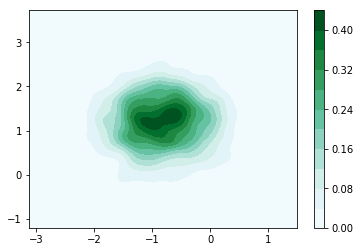

In [264]:
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [277]:
X_embeddeds = TSNE(n_components=2).fit_transform(samples)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


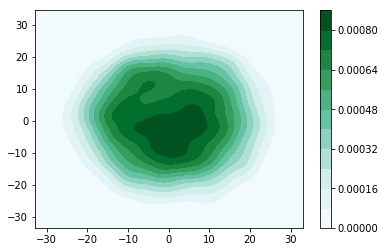

In [279]:
sns.kdeplot(X_embeddeds[:, 0], X_embeddeds[:, 1], shade=True,  cbar=True)

In [194]:
import utils
import time  

In [195]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GM.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [196]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GM, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GM, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.4137    12.8100     2.2361    14.9600    45.1423
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1792    22.4883     2.1099    29.9800    45.8918
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     1.9677    38.5583     1.7556    51.8600    46.2762
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     1.4053    62.8650     1.0324    72.9600    47.0621
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [204]:
# columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
# for epoch in range(0, 10 + 1):
#     time_ep = time.time()

#     lr = 1e-4
#     utils.adjust_learning_rate(optimizer, lr)

#     train_res = utils.train(loaders['train'], GM, optimizer, criterion, regularizer)
#     test_res = utils.test(loaders['test'], GM, criterion, regularizer)

#     time_ep = time.time() - time_ep
#     values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
#               test_res['accuracy'], time_ep]

#     table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
#     print(table)

In [249]:
class GMMultyLayer(nn.Module):
    def __init__(self, n_dim=809):
        super(GMMultyLayer, self).__init__()
        self.n_dim = n_dim
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_bf = torch.FloatTensor(np.random.normal(size=(10, )))
        self.bf = nn.Parameter(data = data_bf, requires_grad=True)

    def sample(self, K):
        e = torch.randn((K, self.mean.size()[0]))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=4000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784]
        
        W2 = W[:, 785]
        b2 = W[:, 786]
        Wf =  W[:, -10:].transpose(0,1)
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        for i in range(int(self.n_dim-784-10/2), 2):
            Wi = W[:, 785+i]
            bi = W[:, 786+i]
            x = self.relu(Wi*x+bi)
            
        x = F.linear(x, Wf, self.bf) 
        x = 1/K*x
#         print(x.shape)
        return x

In [250]:
GML = GMMultyLayer()

In [251]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GML.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [252]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GML, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GML, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.7916    14.3017     2.2235    14.8000    93.5746
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1833    15.8317     2.1439    18.0300    91.0075
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.0937    24.0500     2.0191    30.7600    90.9785
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     1.9095    36.9383     1.7213    47.6100    90.6315
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [253]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GML, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GML, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     0.4101    88.4483     0.3863    89.3100    92.6334
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     0.3955    88.7250     0.3717    89.1300    92.4219
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     0.3859    88.8683     0.3627    89.2800  2193.4165
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     0.3745    89.2933     0.3535    89.7500   104.7829
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  

In [254]:
test_res = utils.test(loaders['test'], GML, criterion, regularizer)

In [255]:
test_res 

{'accuracy': 90.64, 'loss': 0.3292593550682068, 'nll': 0.3292593550682068}

## Distance

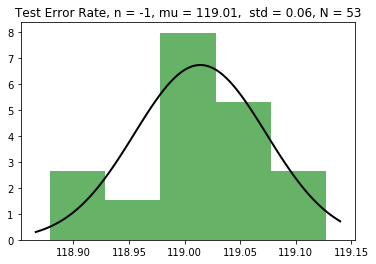

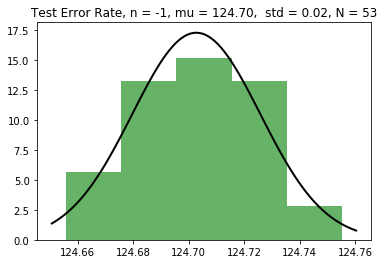

In [44]:
plot_stat(-1, bins=5, name='100middle_point_stat.p')
plot_stat(-1, bins=5, name='2middle_point_stat.p')

## Error 

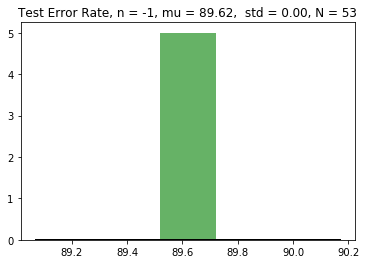

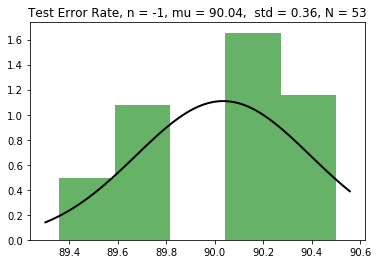

In [42]:
plot_stat(-1, bins=5, name='100middle_point_stat.p')
plot_stat(-1, bins=5, name='2middle_point_stat.p')

##  Test Error for point from 1 to 15 

In [17]:
def plot_stat(n, bins=5, name = None):
    if name is None:
        name = "middle_point_stat_"+str(n)+".p"
    statistic = pickle.load(open('stats2/'+name, "rb"))
    statistic = [s[1:] for s in statistic]
    statistic = np.array(statistic)

#     print(len(statistic))

    # Fit a normal distribution to the data:
    x = statistic[:, 0]
#     x = 100 - statistic[:, -1]
    mu, std = norm.fit(x)

    # Plot the histogram.
    plt.hist(x, bins=bins, alpha=0.6,density=True, color='g')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Test Error Rate, n = %.i, mu = %.2f,  std = %.2f, N = %.f" % (n, mu, std, len(statistic))
    plt.title(title)

    plt.show()

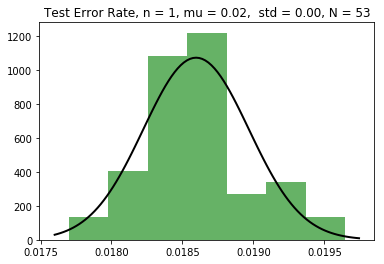

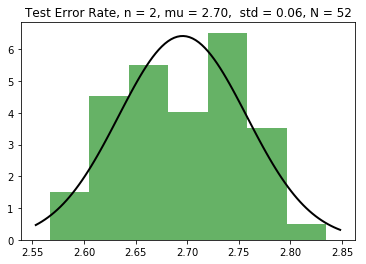

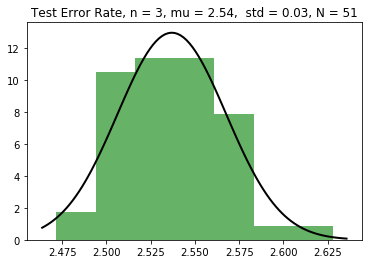

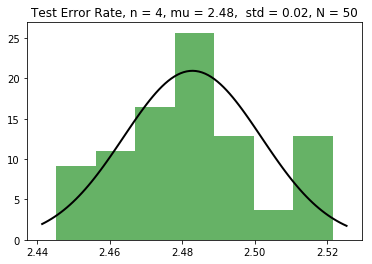

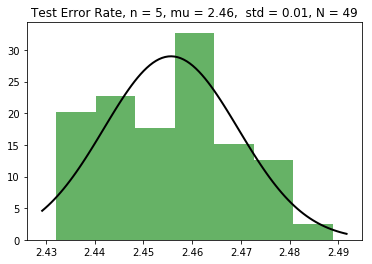

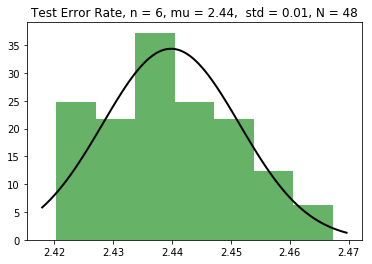

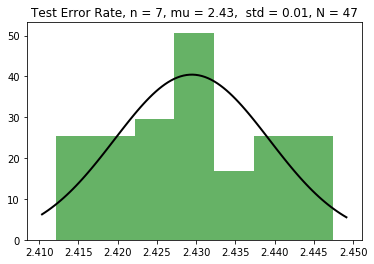

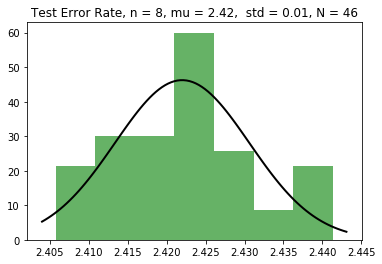

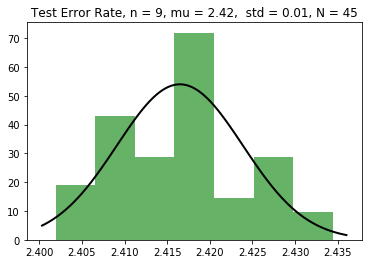

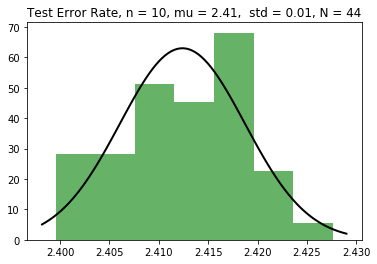

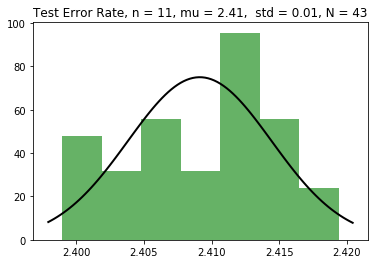

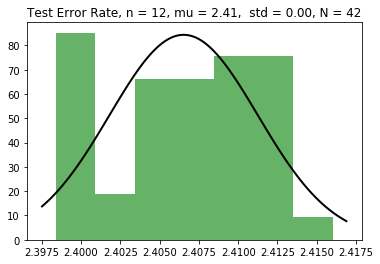

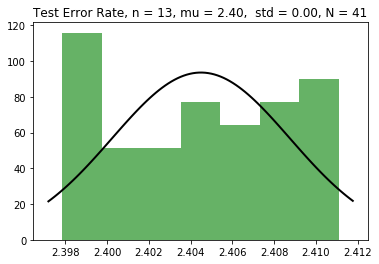

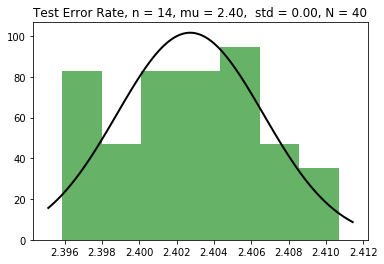

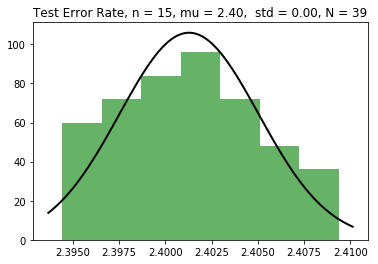

In [18]:
for i in range(1, 16):
    plot_stat(i, bins=7)